In [1]:
%matplotlib inline

In [440]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_dataframe_XYZ_pivot_tables(df, data_column,
                                   x_values_column=None,
                                   y_values_column=None):
    """
    Returns X, Y, Z dataframes corresponding to a 2D pivot of the
    given dataframe along X, Y. Expects a 2+ level multi-index and/or
    for x_values_column and y_values_column parameters to be given.
    'X' corresponds to pivot table column, and 'Y' to pivot table
    index, so that returned dataframes' .values attributes are
    plottable 2D matrices.

    If dataframe is 2+ level indexed _and_ one or both columns given,
    the indices will be used to determine row/col of data in table,
    but the values in X/Y matrix will utilize the [x/y]_values_column.
    Otherwise, X/Y values will be sorted numerically, although extra
    multi-index levels above two will be retained (in terms of .values,
    equivalent to stacking all 2D sub-dataframes along the y-axis).
    """
    # flatten as pivot_table() handles errors much better than unstack()
    if df.index.nlevels == 1:
        if (x_values_column is None) or (y_values_column is None):
            raise ValueError("plot_dataframe_2d requires either a 2+ level " +
                             "multi-indexed dataframe or both x_- and y_- " +
                             "values_column parameters to be given.")
        excess_index_columns = []
        x_index_column = x_values_column + '_copy'
        y_index_column = y_values_column + '_copy'
        flatdf = df.reset_index()  # just in case index important
        flatdf[x_index_column] = flatdf[x_values_column]
        flatdf[y_index_column] = flatdf[y_values_column]
    else:
        excess_index_columns = list(df.index.names[:-2])
        y_index_column = df.index.names[-2]
        x_index_column = df.index.names[-1]
        flatdf = df.reset_index()
        if x_values_column is None:
            x_values_column = x_index_column + '_copy'
            flatdf[x_values_column] = flatdf[x_index_column]
        if y_values_column is None:
            y_values_column = y_index_column + '_copy'
            flatdf[y_values_column] = flatdf[y_index_column]
    # add back any extra columns above 2d to keep y-axis ordering.
    pivot_index_columns = excess_index_columns + [y_index_column]
    # just quick-check to make sure these calls don't fail:
    flatdf[data_column]
    flatdf[x_values_column]
    flatdf[y_values_column]
    flatdf[pivot_index_columns]
    flatdf[x_index_column]
    pivot_df = flatdf.pivot_table(values=[data_column, x_values_column, y_values_column],
                                  index=pivot_index_columns,
                                  columns=[x_index_column],
                                  aggfunc=lambda x: x.head(1),
                                  fill_value=0)
    xvals_df = pivot_df[x_values_column]  # pd.DataFrames in meshgrid()-style 
    yvals_df = pivot_df[y_values_column]
    zvals_df = pivot_df[data_column]
    return xvals_df, yvals_df, zvals_df

def get_dataframe_2d_matrix_and_axes_vecs(df, data_column,
                                          x_values_column=None,
                                          y_values_column=None):
    X, Y, Z = get_dataframe_XYZ_pivot_tables(df, data_column,
                                             x_values_column,
                                             y_values_column)
    x_s = X.iloc[0]  # pd.Series w/matching x/y-dimensional indexing
    y_s = Y.T.iloc[0]
    return x_s.values, y_s.values, Z.values

# helper fcn for labelling axes with nonconsecutive values:
def get_inflection_points(values):
    trend_sign = np.sign(values[1] - values[0])
    vals_iterator = enumerate(values)
    last_ind, last_val = next(vals_iterator)  # pop off and add first (ind, val) pair
    inflection_point_indices = [last_ind]
    inflection_point_values = [last_val]
    for ind, val in yvals_iterator:
        if np.sign(val - last_val) == -1 * trend_sign:
            trend_sign = -1 * trend_sign
            inflection_point_indices.append(last_ind)
            inflection_point_values.append(last_val)
        last_ind, last_val = ind, val
    inflection_point_indices.append(ind)  # add last (ind, val) pair, too
    inflection_point_values.append(val)
    return inflection_point_indices, inflection_point_values

def plot_dataframe_2d(df, data_column,
                      x_values_column=None, y_values_column=None,
                      xlabel=None, ylabel=None,
                      ax=None, **imshow_kwargs):
    xvec, yvec, Zmat = \
        get_dataframe_2d_matrix_and_axes_vecs(df, data_column,
                                              x_values_column,
                                              y_values_column)
    nx, ny = len(xvec), len(yvec)
    if ax is None:
        plt.figure()
        ax = plt.subplot(111)
    if 'extent' not in imshow_kwargs.keys():
        imshow_kwargs['extent'] = [min(xvec), max(xvec),
                                   min(yvec), max(yvec)]
    width = imshow_kwargs['extent'][1] - imshow_kwargs['extent'][0]
    height = imshow_kwargs['extent'][3] - imshow_kwargs['extent'][2]
    natural_aspect_ratio = width / height
    if 'aspect' in imshow_kwargs.keys():
        imshow_kwargs['aspect'] *= natural_aspect_ratio
    else:
        imshow_kwargs['aspect'] = 1.6 * natural_aspect_ratio
    if 'cmap' not in imshow_kwargs.keys():
        imshow_kwargs['cmap'] = 'jet'
    if 'interpolation' not in imshow_kwargs.keys():
        imshow_kwargs['interpolation'] = 'nearest'
    ax.imshow(Zmat, **imshow_kwargs)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    plt.show()

#     def get_axis_ticks(axis_values, use_inflection_points=False):
#         if use_inflection_points:
#             label_indices, label_values = get_inflection_points(axis_data_series)
#             if len(label_indices) > 2:  # keep only if not just linear
#                 return label_indices, label_values
#         else:
#             if len(axis_data_series) < 6:
#                 return axis_data_series.index, axis_data_series.values
#         iloc_indices_to_use = np.linspace(0, len(axis_data_series) - 1,
#                                           num_evenly_spaced_indices)
#         iloc_indices_to_use = np.int64(np.trunc(iloc_indices_to_use))
#         label_indices = axis_data_series.index.values[iloc_indices_to_use]
#         label_values = axis_data_series.loc[label_indices]
#         return label_indices, label_values

#     plot_label_column_names = ['wavelength', 'pump_power']
#     plotlabel = "\n".join(['{}: {}'.format(colname, dataframe.loc[run_id][colname].iloc[0])
#                            for colname in plot_label_column_names])
#     ax.text(1.1, 0.9, plotlabel, verticalalignment='top', horizontalalignment='left',
#             transform=ax.transAxes, color='black', fontsize=16)

#     x_tick_label_indices, x_tick_label_values = get_axis_ticks(x_s,
#                                                                use_inflection_points=False)
#     x_tick_labels = ["{}".format(val)
#                      for val in x_tick_label_values]
#     y_tick_label_indices, y_tick_label_values = get_axis_ticks(y_s,
#                                                                use_inflection_points=False)
#     y_tick_labels = ["{}".format(val)
#                      for val in y_tick_label_values]
#     if x_tick_label_indices is not None:
#         plt.xticks(x_tick_label_indices, x_tick_labels)
#     if y_tick_label_indices is not None:
#         plt.yticks(y_tick_label_indices, y_tick_labels)

# def plot_2d_with_run_id_slider(dataframe, data_column,
#                                x_values_column=None, y_values_column=None):
#     """
#     Expects a 3-level-multi-indexed dataframe and a column name corresponding
#     to the value to be plotted. Optionally, columns containing values corresponding
#     to each axis can be provided, otherwise the labels in the dataframe's index
#     will be used.
#     """
#     def plot_2d_by_3rd_index(dataframe, third_index):
#         plot_dataframe_2d(dataframe.xs(third_index, level=-3), 
#                           data_column, x_values_column, y_values_column)

#     run_id_slider = widgets.IntSlider(min=0, max=dataframe.index.get_level_values('run_id').max(),
#                                       value=0, description='Run ID:')
#     widgets.interact(plot_2d_by_3rd_index, dataframe=widgets.fixed(dataframe), run_id=run_id_slider);


# Simulation Data

In [441]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=4., y=4.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


b_external  kerr_rotation  probe_delay
run_id index_2d index_1d                                        
1      -940     11             200.0      -0.000010       -172.0
                12             200.0      -0.000020       -144.0
                13             200.0       0.000004       -116.0
                14             200.0       0.000018        -88.0
                15             200.0      -0.000025        -60.0

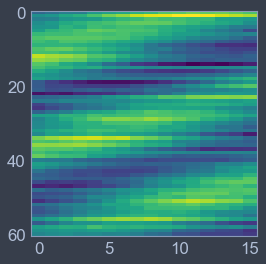

In [442]:
import experimentdataanalysis.simulations.simple_trkr_rsa_simulation as simple_trkr_rsa_simulation

# independent params
seed = 10

ndatasets = 61
nx = 16
dataset_bvals = np.linspace(200, 230, ndatasets)
tvals = np.linspace(-480, -60, nx)

# TEMP - full TRKR scans over huge B-range
# ndatasets = 51
# nx = 251
# dataset_bvals = np.linspace(0, 200, ndatasets)
# tvals = np.linspace(-500, 7000, nx)

# simulation constants & randomly generated params
simulation_constants = {
    'pulse_amplitude_mean': 1e-3,
    'pulse_amplitude_std_err': 2e-5,
    'gfactor': 0.439,
    'spin_lifetime_mean': 10000,
    'spin_lifetime_std_err': 2000,
    'initial_phase': 0.0 * np.pi,
    'extra_phase_offset_baseline': 0.0 * np.pi,
    'extra_phase_offset_cos_amp': 0.1 * np.pi,
    'extra_phase_offset_cos_nperiods': 3.0,
    'slopes_scale': 0.0,
    'offsets_scale': 1e-4,
    'noise_scale': 2e-5,
}

simulation_params_1 = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_params(nx, ndatasets,
                                                               simulation_constants, seed)
dataframe_1 = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_dataframe(tvals, dataset_bvals,
                                                                  simulation_params,
                                                                  suppress_plot=False)
simulation_params_2 = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_params(nx, ndatasets,
                                                               simulation_constants, seed + 1)
dataframe_2 = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_dataframe(tvals, dataset_bvals[::-1],
                                                                  simulation_params,
                                                                  suppress_plot=True)
dataframe_2.index.map(lambda x: (x[0] + 1, x[1], x[2]))
dataframe_2.index = dataframe_2.index.map(lambda x: (x[0] + 1, x[1] - 1000, x[2]))
dataframe_2.index.set_names(dataframe_1.index.names)
dataframe = pd.concat([dataframe_1, dataframe_2])
dataframe.tail(5)

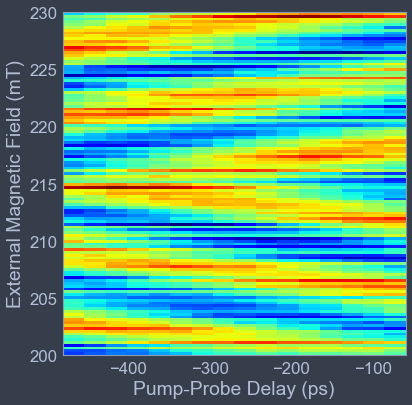

In [444]:
# TEST WITH >2D INDICES
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
data_column = 'kerr_rotation'
x_values_column = 'probe_delay'
y_values_column = 'b_external'
xlabel = 'Pump-Probe Delay (ps)'
ylabel = 'External Magnetic Field (mT)'
imshow_kwargs = {'aspect': 1.0}
plot_dataframe_2d(dataframe,
                  data_column,
                  x_values_column=x_values_column,
                  y_values_column=y_values_column,
                  xlabel=xlabel, ylabel=ylabel,
                  ax=ax, **imshow_kwargs)